In [37]:
import boto3
from dotenv import load_dotenv
import os
import logging
import matplotlib.pyplot as plt
from typing import Dict, Any, Optional, List
import pandas as pd
import numpy as np
import seaborn as sns

plt.style.use("ggplot")
sns.set_theme(style="white")


# Configure the logging system
logging.basicConfig(
    level=logging.INFO # We set the logging level to INFO so that INFO and above messages are logged
)

logger = logging.getLogger(__name__)

load_dotenv()

LOCAL_DIR = "data"

In [2]:
os.listdir(LOCAL_DIR)

['feature_frame.parquet']

In [3]:

bb_df = pd.read_parquet("data/feature_frame.parquet", engine="fastparquet")

In [4]:
bb_df

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880544,33826439594116,healthcarevitamins,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880545,33826439594116,healthcarevitamins,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880546,33826439594116,healthcarevitamins,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880547,33826439594116,healthcarevitamins,3643294515332,3906490826884,2021-03-03 14:30:30,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


In [5]:
info_cols = ["variant_id","order_id","user_id","created_at","order_date"]
label_col = "outcome"
feature_cols = [col for col in bb_df.columns if col not in info_cols + [label_col]]

categorical_cols = ["product_type","vendor"]
binary_cols = ["ordered_before","abandoned_before","active_snoozed","set_as_regular"]
numerical_cols = [col for col in feature_cols if col not in categorical_cols + binary_cols]

In [6]:
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [7]:
bb_df[["variant_id","order_id","outcome"]].head()

,variant_id,order_id,outcome
0,33826472919172,2807985930372,0.0
1,33826472919172,2808027644036,0.0
2,33826472919172,2808099078276,0.0
3,33826472919172,2808393957508,0.0
4,33826472919172,2808429314180,0.0


In [8]:
(
    bb_df.groupby("order_id")["user_id"]
    .nunique()
    .reset_index()
)["user_id"].unique()

array([1])

In [9]:
(
    bb_df.groupby("order_id")["user_id"]
    .nunique() > 1
    ).any()

False

Con esto vemos que la relación entre "order_id" y "user_id" es 1:1

In [10]:
(
    bb_df.groupby("user_id")["order_id"]
    .nunique()
    .reset_index()
    ).max()

user_id     5029635227780
order_id               16
dtype: int64

Sin embargo, como es obvio, un usuario puede hacer más de 1 pedido. El usuario "5029635227780" fue el que más pedidos hizo (16 pedidos), aunque luego no comprara

In [11]:
user = 5029635227780
(bb_df.loc[lambda df:df["user_id"] == user].outcome == 1).sum()

2

Únicamente compró dos ítems

<Axes: xlabel='order_id'>

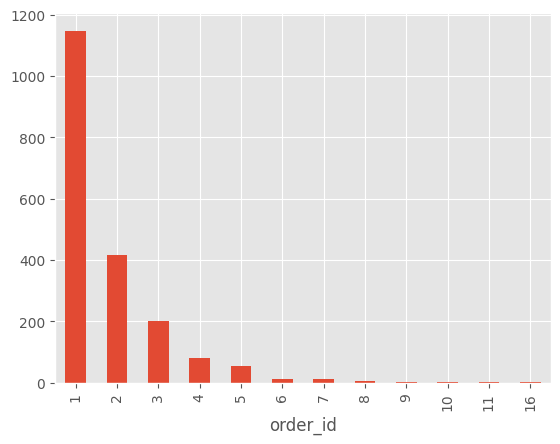

In [12]:
(
    bb_df.groupby("user_id")["order_id"]
    .nunique()
    .reset_index()
)["order_id"].value_counts().sort_index().plot(kind="bar")

In [13]:
filtered_orders = ( 
    bb_df.groupby(["order_id"])["outcome"]
    .sum()
    .reset_index()
    .loc[lambda df:df["outcome"].ge(5)]
)["order_id"]

filtered_orders

0       2807985930372
1       2808027644036
2       2808099078276
3       2808393957508
5       2808434524292
            ...      
3438    3643241300100
3441    3643254800516
3442    3643274788996
3443    3643283734660
3444    3643294515332
Name: order_id, Length: 2603, dtype: int64

In [28]:
filtered_df = bb_df.loc[lambda df:df["order_id"].isin(filtered_orders)].copy()
filtered_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


<Axes: xlabel='product_type'>

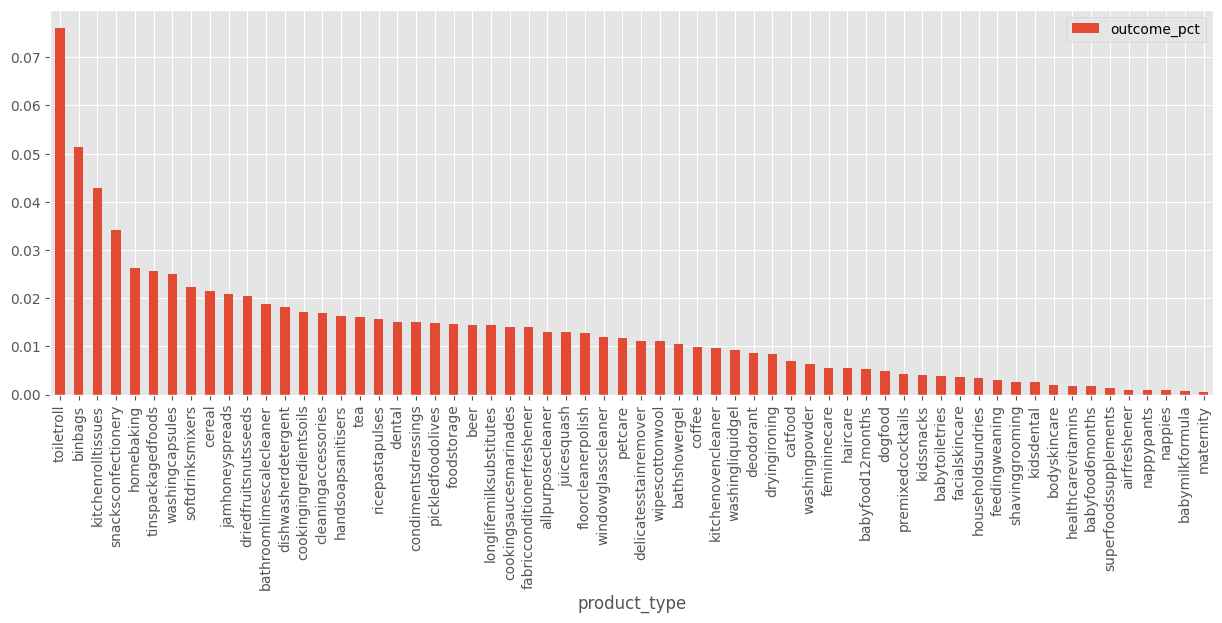

In [15]:
(
    filtered_df.groupby("product_type")["outcome"]
    .mean()
    .reset_index()
    .rename(columns = {"outcome":"outcome_pct"})
    .sort_values("outcome_pct", ascending=False)
    ).plot(kind="bar", x="product_type",figsize=(15,5))

<Axes: xlabel='vendor'>

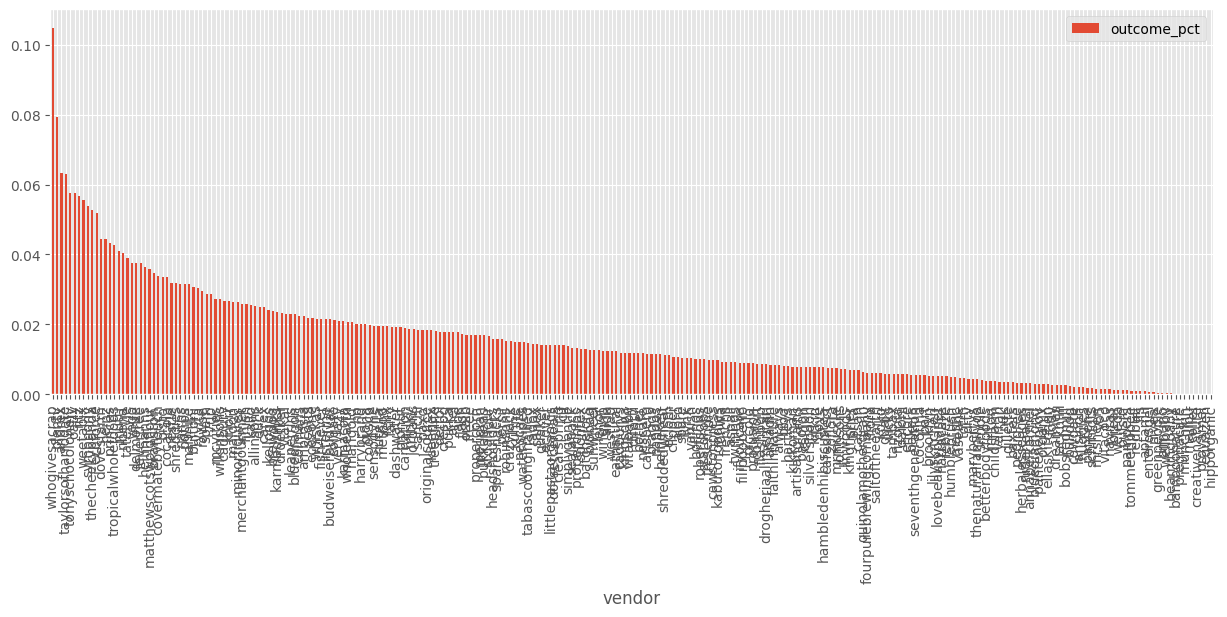

In [16]:
(
    filtered_df.groupby("vendor")["outcome"]
    .mean()
    .reset_index()
    .rename(columns = {"outcome":"outcome_pct"})
    .sort_values("outcome_pct", ascending=False)
    ).plot(kind="bar", x="vendor",figsize=(15,5))

In [29]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      float64

In [32]:
filtered_df["product_type_freq"] = filtered_df["product_type"].map(
    filtered_df["product_type"]
    .value_counts(normalize=True)
    )

filtered_df["vendor_freq"] = filtered_df["vendor"].map(
    filtered_df["vendor"]
    .value_counts(normalize=True)
    )

filtered_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_freq,vendor_freq
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0.044619,0.014435
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0.044619,0.014435
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0.044619,0.014435
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0.044619,0.014435
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0.044619,0.014435


In [44]:
cols_to_drop = filtered_df.select_dtypes(include=["object"]).columns
df = filtered_df.drop(columns=cols_to_drop)
df

,variant_id,order_id,user_id,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_freq,vendor_freq
0,33826472919172,2807985930372,3482464092292,3,0.0,0.0,0.0,0.0,0.0,0.081052,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
1,33826472919172,2808027644036,3466586718340,2,0.0,0.0,0.0,0.0,0.0,0.081052,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
2,33826472919172,2808099078276,3481384026244,4,0.0,0.0,0.0,0.0,0.0,0.081052,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
3,33826472919172,2808393957508,3291363377284,2,0.0,0.0,0.0,0.0,0.0,0.081052,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
5,33826472919172,2808434524292,3479090790532,3,0.0,0.0,0.0,0.0,0.0,0.081052,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880541,33826439594116,3643241300100,3864791220356,2,0.0,0.0,0.0,0.0,0.0,0.417186,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203
2880544,33826439594116,3643254800516,3893722808452,3,0.0,0.0,0.0,0.0,0.0,0.417186,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203
2880545,33826439594116,3643274788996,3883757174916,4,0.0,0.0,0.0,0.0,0.0,0.417186,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203
2880546,33826439594116,3643283734660,3874925314180,7,0.0,0.0,0.0,0.0,0.0,0.417186,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203


In [46]:
df = df.drop(columns= ["variant_id","order_id","user_id"])
df

,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_freq,vendor_freq
0,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
1,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
2,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
3,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.038462,2.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
5,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.038462,2.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880541,2,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,0.000000,2.0,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203
2880544,3,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,0.000000,2.0,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203
2880545,4,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,0.000000,2.0,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203
2880546,7,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,0.000000,2.0,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 22 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   user_order_seq                    int64  
 1   outcome                           float64
 2   ordered_before                    float64
 3   abandoned_before                  float64
 4   active_snoozed                    float64
 5   set_as_regular                    float64
 6   normalised_price                  float64
 7   discount_pct                      float64
 8   global_popularity                 float64
 9   count_adults                      float64
 10  count_children                    float64
 11  count_babies                      float64
 12  count_pets                        float64
 13  people_ex_baby                    float64
 14  days_since_purchase_variant_id    float64
 15  avg_days_to_buy_variant_id        float64
 16  std_days_to_buy_variant_id        float64

Correlation plot

<Axes: >

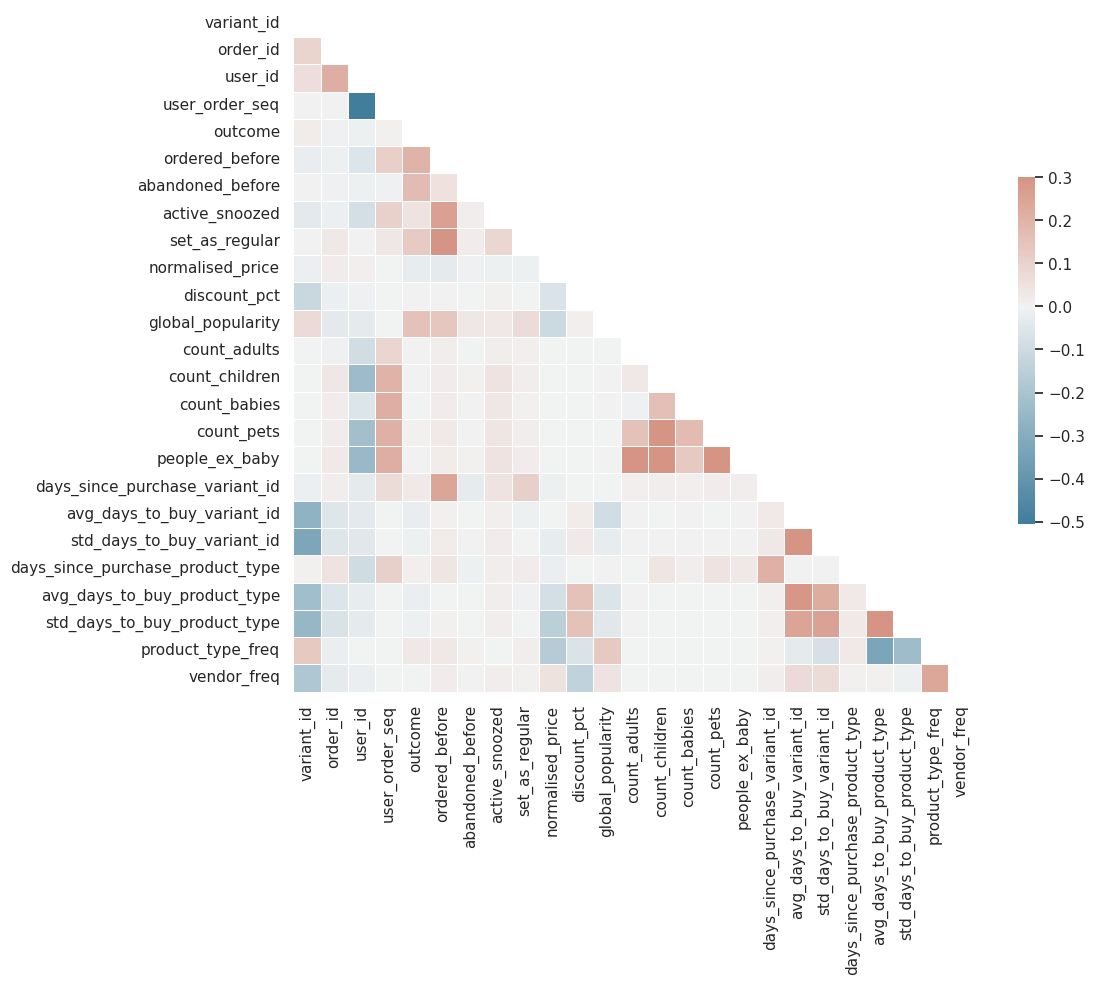

In [38]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Linear Regression

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [56]:
X = df.drop(columns=["outcome"])
y = df["outcome"]


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train)/len(df)}")
print(f"Val size:   {len(X_val)/len(df)}")
print(f"Test size:  {len(X_test)/len(df)}")


Train size: 0.6999999537882754
Val size:   0.15000002310586227
Test size:  0.15000002310586227


In [57]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [58]:
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

In [67]:

def evaluate_model(y_val, y_val_pred, y_test, y_test_pred):
    # Validation metrics
    val_rmse = mean_squared_error(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    # Test metrics
    test_rmse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print("Validation Metrics:")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"MAE:  {val_mae:.4f}")
    print(f"R²:   {val_r2:.4f}")

    print("\nTest Metrics:")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE:  {test_mae:.4f}")
    print(f"R²:   {test_r2:.4f}")

evaluate_model(y_val, y_val_pred, y_test, y_test_pred)

Validation Metrics:
RMSE: 0.0131
MAE:  0.0264
R²:   0.0847

Test Metrics:
RMSE: 0.0131
MAE:  0.0264
R²:   0.0828


In [2]:
from sklearn.linear_model import Lasso, Ridge

In [3]:
lasso = Lasso(alpha=0.0003, random_state=42)  # puedes ajustar alpha
lasso.fit(X_train, y_train)

y_val_pred = lasso.predict(X_val)
y_test_pred = lasso.predict(X_test)

evaluate_model(y_val, y_val_pred, y_test, y_test_pred)


NameError: name 'X_train' is not defined